# SMPL: A Skinned Multi-Person Linear Model
Before starting the tutorial, you need to download the SMPL model files. You can obtain them from the official [SMPL website](https://smpl.is.tue.mpg.de/). In this tutorial, we use 300 shape PCs for the SMPL model since it covers female/male/neutral and is more commonly used in the community.

After download, you have to rename the files:
- `basicmodel_neutral_lbs_10_207_0_v1.1.0.pkl` -> `SMPL_NEUTRAL.pkl`
- `basicmodel_f_lbs_10_207_0_v1.1.0` -> `SMPL_FEMALE.pkl`
- `basicmodel_m_lbs_10_207_0_v1.1.0.pkl` -> `SMPL_MALE.pkl`


Packages you need to install for this tutorial:
```bash
smplx   # It installs torch and numpy as dependencies
scipy
chumpy @ git+https://github.com/mattloper/chumpy
matplotlib
pyrender  # Installs trimesh as a dependency
```

**Note:** Installing chumpy as `pip install chumpy` may lead to errors during model initialization. Please make sure to install it from the GitHub repository as shown above.

In [1]:
from smplx import SMPL
import matplotlib.pyplot as plt
import pyrender
import trimesh
import torch
import numpy as np
import os

In [2]:
SMPL_MODEL_PATH = 'parametric_models/smpl'
neutral_model = SMPL(SMPL_MODEL_PATH, gender='neutral')
male_model = SMPL(SMPL_MODEL_PATH, gender='male')
female_model = SMPL(SMPL_MODEL_PATH, gender='female')

In [3]:
# Using default values for pose, shape, and translation
pose = torch.zeros([1, 72])
betas = torch.zeros([1, 10])
translation = torch.zeros([1, 3])

out_neutral = neutral_model(global_orient=pose[:, :3],
                            body_pose=pose[:, 3:], 
                            betas=betas,
                            transl=translation)

In [4]:
out_neutral.vertices.shape, out_neutral.joints.shape

(torch.Size([1, 6890, 3]), torch.Size([1, 45, 3]))

In [5]:
neutral_model.parents

tensor([-1,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9,  9, 12, 13, 14,
        16, 17, 18, 19, 20, 21])

### Visualization using matplotlib

In [6]:
def visualize(points, point_size=1, parents=None, colors=None):
    # Drop batch dimension
    pts = points[0].detach().cpu().numpy()

    x = pts[:, 0]
    y = pts[:, 1]
    z = pts[:, 2]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, s=point_size, c=colors, cmap='tab20')

    # Optionally draw bones from i -> parents[i]
    if parents is not None:
        parents = parents.numpy()

        for child_idx, parent_idx in enumerate(parents):
            if parent_idx == -1:
                continue
            ax.plot([x[child_idx], x[parent_idx]],
                    [y[child_idx], y[parent_idx]],
                    [z[child_idx], z[parent_idx]])


    max_range = np.array([
        x.max() - x.min(),
        y.max() - y.min(),
        z.max() - z.min()
    ]).max()

    mid_x = 0.5 * (x.max() + x.min())
    mid_y = 0.5 * (y.max() + y.min())
    mid_z = 0.5 * (z.max() + z.min())

    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Make it y-up (your original view)
    ax.view_init(elev=120, azim=-90)

    plt.show()

/tmp/ipykernel_267192/4050711238.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, z, s=point_size, c=colors, cmap='tab20')


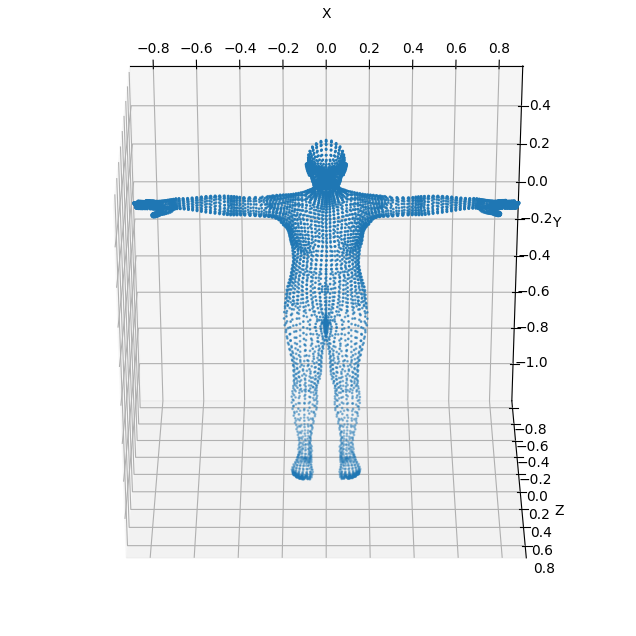

In [7]:
visualize(out_neutral.vertices)

/tmp/ipykernel_267192/4050711238.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, z, s=point_size, c=colors, cmap='tab20')


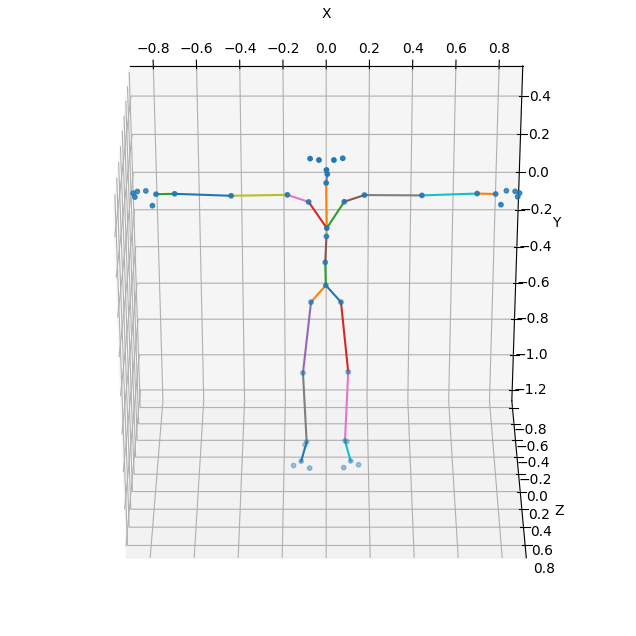

In [8]:
visualize(out_neutral.joints, point_size=10, parents=neutral_model.parents)

### How to change the pose?
The joint ordering of SMPL is as follows:

![https://user-images.githubusercontent.com/38954558/209543786-98932193-f343-4b67-b388-7e20181e2314.png](https://user-images.githubusercontent.com/38954558/209543786-98932193-f343-4b67-b388-7e20181e2314.png)

/tmp/ipykernel_267192/4050711238.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, z, s=point_size, c=colors, cmap='tab20')


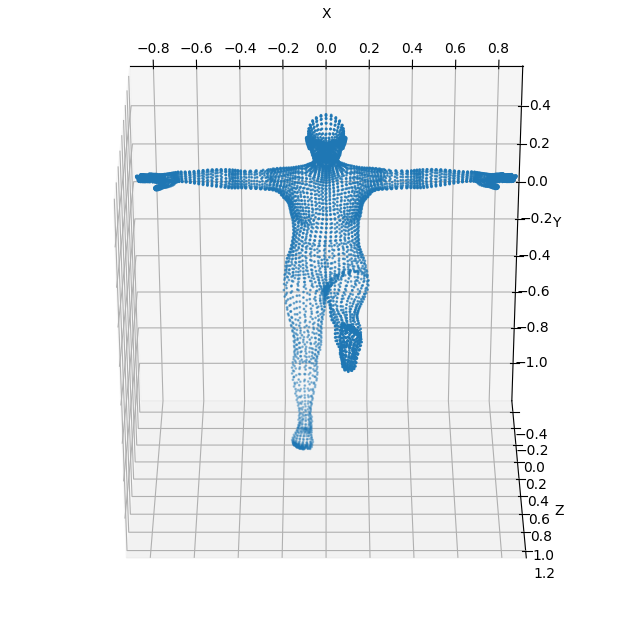

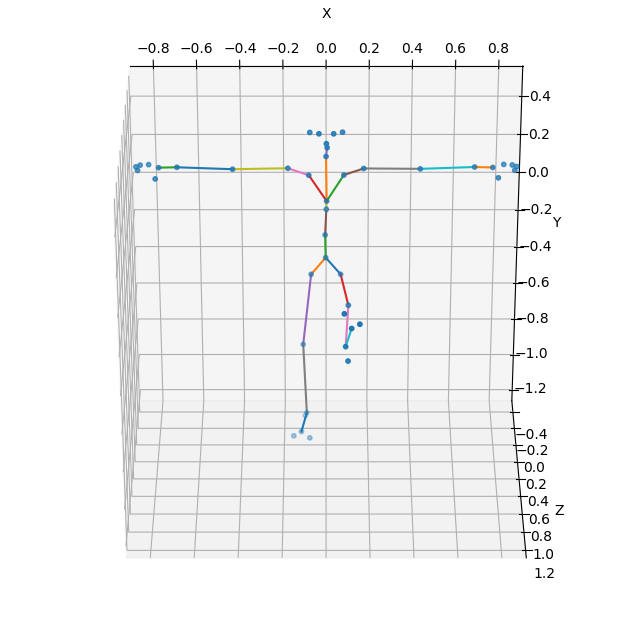

In [9]:
pose = torch.zeros([1, 24, 3])
pose[0, 1, 0] = np.deg2rad(-90)
pose = pose.view(1, 72)

out_neutral = neutral_model(global_orient=pose[:, :3],
                            body_pose=pose[:, 3:], 
                            betas=betas,
                            transl=translation)
visualize(out_neutral.vertices), visualize(out_neutral.joints, point_size=10, parents=neutral_model.parents);

## How to segment SMPL body parts?
We can leverage the LBS weights to segment the body parts.

In [10]:
neutral_model.lbs_weights.shape

torch.Size([6890, 24])

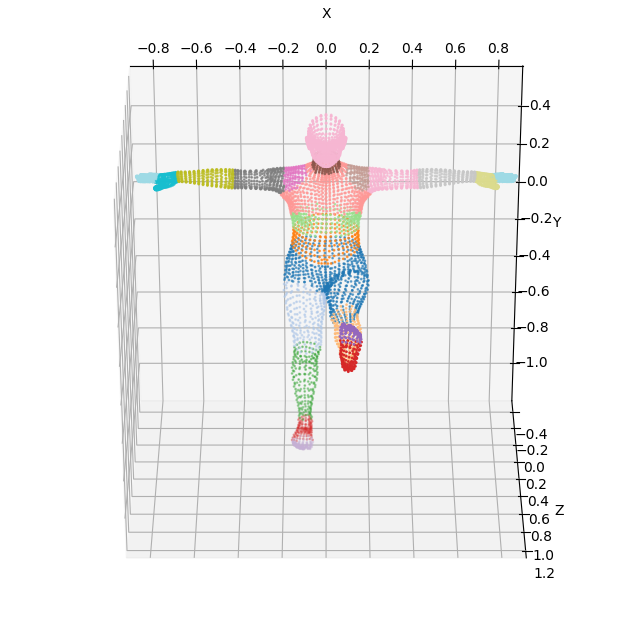

In [11]:
vertex_clusters = torch.argmax(neutral_model.lbs_weights, dim=1)  # (6890,)
visualize(out_neutral.vertices, point_size=1, colors=vertex_clusters)

## How to render and see the actual faces (triangles)?

In [12]:
neutral_model.faces.shape

(13776, 3)

In [13]:
os.environ["PYOPENGL_PLATFORM"] = "egl"  # For headless rendering

def render(vertices, faces, image_size=(800, 800)):
    vertices = vertices[0].cpu().numpy()

    # ---- Build mesh ----
    mesh = trimesh.Trimesh(vertices=vertices,
                           faces=faces,
                           process=False)
    pm = pyrender.Mesh.from_trimesh(mesh, smooth=True)

    # ---- Scene ----
    scene = pyrender.Scene(bg_color=np.zeros(4))
    # Add mesh
    scene.add(pm)
    
    # ---- Auto center ----
    center = mesh.bounds.mean(axis=0)
    extents = mesh.extents
    radius = np.linalg.norm(extents) * 0.5

    # ---- Camera ----
    camera = pyrender.PerspectiveCamera(yfov=np.deg2rad(45.0))
    scene.add(
        camera,
        pose=np.array([
            [1, 0, 0, center[0]],
            [0, 1, 0, center[1]],
            [0, 0, 1, center[2] + 2.5 * radius],
            [0, 0, 0, 1],
        ])
    )

    # ---- Light (simple directional) ----
    light = pyrender.DirectionalLight(color=np.ones(3), intensity=3.0)
    scene.add(
        light,
        pose=np.array([
            [1, 0, 0, center[0]],
            [0, 1, 0, center[1] + radius],
            [0, 0, 1, center[2] + radius],
            [0, 0, 0, 1],
        ])
    )

    # ---- Render ----
    w, h = image_size
    r = pyrender.OffscreenRenderer(w, h)
    color, _ = r.render(scene)
    r.delete()

    return color


def visualize_img(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

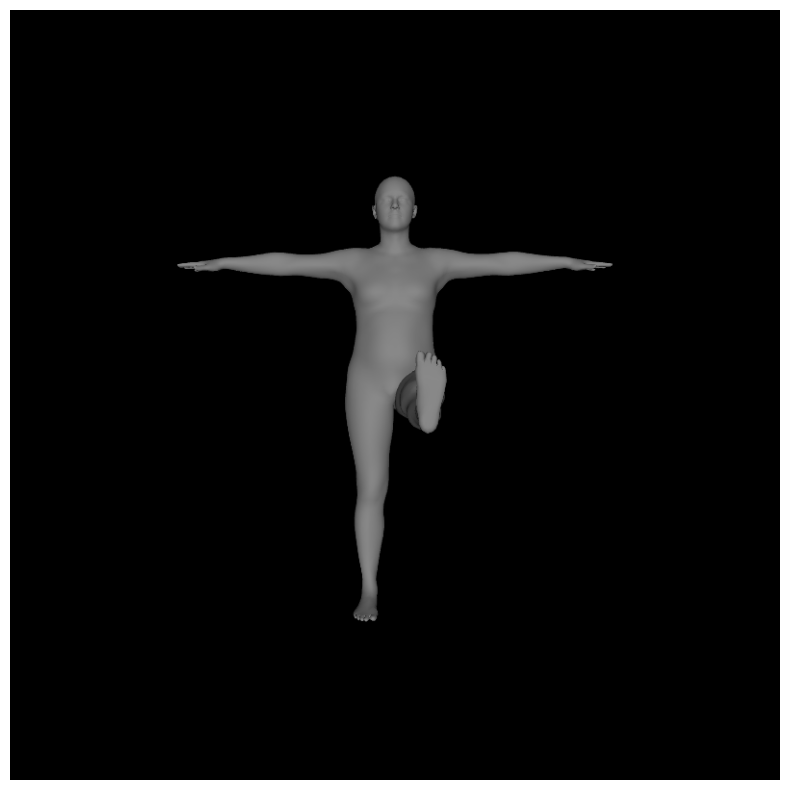

In [14]:
rendered_img = render(out_neutral.vertices, neutral_model.faces)
visualize_img(rendered_img)